# Imports

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import math

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline as skPipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SequentialFeatureSelector


from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline
sns.set_theme(
    style="whitegrid",
    rc={
        "axes.facecolor": "white",
        "grid.color": "0.9",
        "axes.edgecolor": "0.9",
        "axes.labelcolor": "#333333",
        "xtick.color": "#333333",
        "ytick.color": "#333333",
        "font.size": 12,
        "axes.titlesize": 18,
        "axes.titleweight": "bold",
    }
)

# Read data into DFs

In [101]:
# 1. Column names (15 features + label)
headers = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'pred'   # label (<=50K / >50K)
]

# 2. Read raw data
original_train_df = pd.read_csv(
    "census-income.data.csv",
    header=None,
    names=headers,
    index_col=False
)

original_test_df = pd.read_csv(
    "census-income.test.csv",
    header=None,
    names=headers,
    index_col=False
)

# Work on copies
train_df = original_train_df.copy()
test_df = original_test_df.copy()

In [102]:
# Transform target into binary

target_map = {
'<=50K': 0,
'>50K': 1,
'<=50K.': 0,
'>50K.': 1
}

train_df['pred'] = train_df['pred'].str.strip().map(target_map)
test_df['pred'] = test_df['pred'].str.strip().map(target_map)

In [103]:
# ---------- Helper Functions ----------

def data_to_str(df):
    """Strip leading/trailing spaces from all object columns."""
    df = df.copy()
    str_cols = df.select_dtypes(include=["object"]).columns
    for col in str_cols:
        df[col] = df[col].str.strip()
    return df

def replace_qmarks(df):
    """Convert '?' to np.nan."""
    return df.replace("?", np.nan)


def category_remapping(df):
    '''Maps categorical variables into more functional bins'''
    copy_df = df.copy()
    
    # workclass
    workclass_mapping = {
        'State-gov':'Government',
        'Local-gov':'Government',
        'Federal-gov':'Government',
        'Self-emp-inc':'Incorporated-Entrepreneur',
        'Self-emp-not-inc':'Unincorporated-Entrepreneur',
        'Without-pay':'Unemployed',
        'Never-worked':'Unemployed',
        'Private':'Private'
    }
    if "workclass" in copy_df:
        copy_df["workclass-cat"] = copy_df["workclass"].map(workclass_mapping)
    
    # education
    edu_mapping = {
        'Preschool':'HS-dropout',
        '1st-4th':'HS-dropout',
        '5th-6th':'HS-dropout',
        '7th-8th':'HS-dropout',
        '9th':'HS-dropout',
        '10th':'HS-dropout',
        '11th':'HS-dropout',
        '12th':'HS-dropout',
        'HS-grad':'HS-grad',
        'Some-college':'Some-college',
        'Assoc-acdm':'Some-college',
        'Assoc-voc':'Some-college',
        'Bachelors':'Bachelors',
        'Masters':'Advanced-degree',
        'Prof-school':'Advanced-degree',
        'Doctorate':'Advanced-degree'
    }
    if "education" in copy_df:
        copy_df["education-cat"] = copy_df["education"].map(edu_mapping)
    
    # marital-status
    marital_mapping = {
        'Never-married':'Single/Unmarried',
        'Divorced':'Single/Unmarried',
        'Separated':'Single/Unmarried',
        'Widowed':'Single/Unmarried',
        'Married-spouse-absent':'Single/Unmarried',
        'Married-civ-spouse':'Married',
        'Married-AF-spouse':'Married'
    }
    if "marital-status" in copy_df:
        copy_df["marital-cat"] = copy_df["marital-status"].map(marital_mapping)
    
    # occupation
    occupation_mapping = {
        'Exec-managerial':'White-collar',
        'Prof-specialty':'White-collar',
        'Tech-support':'White-collar',
        'Other-service':'Service',
        'Sales':'Service',
        'Adm-clerical':'Service',
        'Protective-serv':'Service',
        'Craft-repair':'Blue-collar',
        'Transport-moving':'Blue-collar',
        'Machine-op-inspct':'Blue-collar',
        'Armed-Forces':'Military',
        'Priv-house-serv':'Manual',
        'Farming-fishing':'Manual',
        'Handlers-cleaners':'Manual'
    }
    if "occupation" in copy_df:
        copy_df["occupation-cat"] = copy_df["occupation"].map(occupation_mapping)
    
    # native-country → native_imm_cat
    if "native-country" in copy_df:
        s = copy_df["native-country"]
        native_imm_cat = (
            s.map({"United-States": "Native"})  # US → Native, others NaN
             .fillna("Immigrant")              # non-US, non-missing → Immigrant
             .where(s.notna(), pd.NA)          # where original was missing, keep NA
        )
        copy_df["native_imm_cat"] = native_imm_cat.replace({pd.NA: np.nan})
    
    # hours-per-week binning
    if "hours-per-week" in copy_df:
        hrs_bins = [0, 30, 40, 60, 100]
        hrs_labels = ["Part-Time", "Underworked", "Full-Time+", "Overworked"]
        copy_df["hours_bin"] = pd.cut(copy_df["hours-per-week"], bins=hrs_bins, labels=hrs_labels)
    
    # capital-flow binning
    if "capital-gain" in copy_df and "capital-loss" in copy_df:
        copy_df["net-capital-flow"] = copy_df["capital-gain"] - copy_df["capital-loss"]
        cap_bins = [-10000, 10000, 99999]
        cap_labels = ["Standard", "High Net-Worth"]
        copy_df["cap_flow_bin"] = pd.cut(copy_df["net-capital-flow"], bins=cap_bins, labels=cap_labels)
    
    # Drop original columns we replaced
    drop_cols = [
        "workclass", "fnlwgt", "education", "education-num",
        "marital-status", "occupation", "native-country",
        "hours-per-week", "capital-gain", "capital-loss",
        "net-capital-flow"
    ]
    existing = [c for c in drop_cols if c in copy_df.columns]
    copy_df = copy_df.drop(columns=existing)
    
    return copy_df


class BasicPrep(BaseEstimator, TransformerMixin):
    """
    1) strip whitespace
    2) convert '?' → np.nan
    3) apply all category/bucket remappings & drop originals
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df = X.copy()
        df = data_to_str(df)
        df = replace_qmarks(df)
        df = category_remapping(df)
        return df


In [104]:
train_df_drop = train_df.copy()

train_df_drop = data_to_str(train_df_drop)
train_df_drop = replace_qmarks(train_df_drop)

### Train Test Split

In [105]:
target_col = "pred"

X_train_raw = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

X_test_raw  = test_df.drop(columns=[target_col])
y_test  = test_df[target_col]

# Logistic Regression
## Build transformers, identify features

In [106]:
numeric_features = ["age"]

categorical_features = [
    "relationship", "race", "sex",
    "workclass-cat", "education-cat", "marital-cat",
    "occupation-cat", "native_imm_cat",
    "hours_bin", "cap_flow_bin"
]

# Numeric pipeline
numeric_transformer = skPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("log", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
    ("scaler", MinMaxScaler())
])

# Categorical pipeline
categorical_transformer = skPipeline(steps=[
    ("imputer", SimpleImputer(
        strategy="most_frequent",   # or "constant" with fill_value="Unknown"
        fill_value="Unknown"
    )),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

## Build pipeline & test using GridSearchCV

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params (LogReg): {'clf__C': 10.0, 'preprocessor__cat__imputer__strategy': 'constant', 'preprocessor__num__log': FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>), 'preprocessor__num__scaler': MinMaxScaler(), 'sampler': 'passthrough'}
Best CV accuracy (LogReg): 0.8424496310723857
Test accuracy (LogReg): 0.8436828204655734
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     12435
           1       0.71      0.57      0.63      3846

    accuracy                           0.84     16281
   macro avg       0.79      0.75      0.77     16281
weighted avg       0.84      0.84      0.84     16281



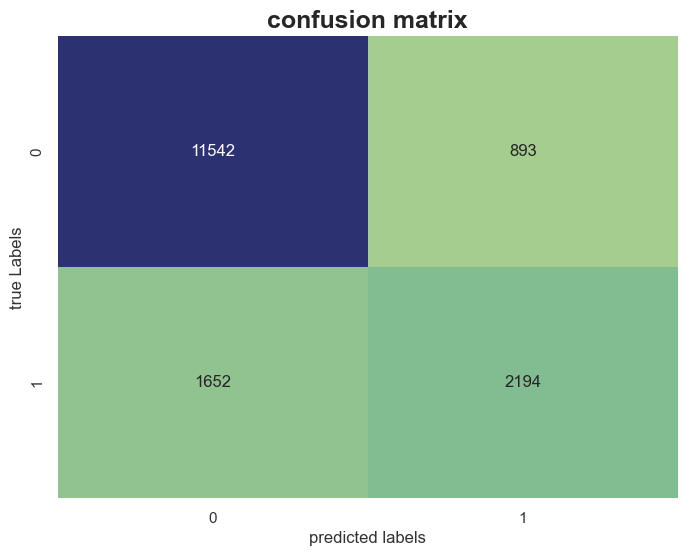

Exception ignored in: <function ResourceTracker.__del__ at 0x1055a72e0>
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106a972e0>
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__

In [126]:
logreg_base = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    solver="lbfgs",
    penalty="l2"
    #class_weight="balanced"
)

logreg_pipeline = ImbPipeline(steps=[
    ("prep", BasicPrep()),
    ("preprocessor", preprocessor),
    ("sampler", "passthrough"),  # will be set to ROS or passthrough in grid
    ("clf", logreg_base),
])

logreg_param_grid = {
    # --- categorical missing-data ---
    "preprocessor__cat__imputer__strategy": ["most_frequent", "constant"],
    # "constant" uses fill_value="Unknown" already set above

    # --- numeric normalization on age ---
    "preprocessor__num__log": [
        "passthrough",
        FunctionTransformer(np.log1p, feature_names_out="one-to-one"),
    ],
    "preprocessor__num__scaler": [
        "passthrough",
        MinMaxScaler(),
    ],

    # --- imbalance handling ---
    "sampler": [
        "passthrough",
        RandomOverSampler(random_state=42),
    ],

    # --- LogisticRegression hyperparams ---
    "clf__C": [0.1, 1.0, 10.0],
}

logreg_grid = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=logreg_param_grid,
    cv=5,
    scoring="accuracy",  # or 'f1_macro' or "accuracy
    n_jobs=-1,
    verbose=1
)

logreg_grid.fit(X_train_raw, y_train)

print("Best params (LogReg):", logreg_grid.best_params_)

print("Best CV accuracy (LogReg):", logreg_grid.best_score_)

print("Test accuracy (LogReg):", logreg_grid.score(X_test_raw, y_test))
print(classification_report(y_test, logreg_grid.predict(X_test_raw)))

y_pred_lr=logreg_grid.predict(X_test_raw)
conf= confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8,6))
sns.heatmap(conf, annot=True, cmap= "crest", fmt="d", cbar=False)
plt.xlabel('predicted labels')
plt.ylabel ('true Labels')
plt.title('confusion matrix')
plt.show()


In [129]:
best_lr_pipe = logreg_grid.best_estimator_
preprocessor_best = best_lr_pipe.named_steps["preprocessor"]
lr_clf = best_lr_pipe.named_steps["clf"]

# numeric feature names
num_transformer = preprocessor_best.named_transformers_["num"]
if hasattr(num_transformer, "get_feature_names_out"):
    feature_names_num = num_transformer.get_feature_names_out(numeric_features)
else:
    feature_names_num = np.array(numeric_features)

# categorical feature names from OneHotEncoder
cat_pipeline = preprocessor_best.named_transformers_["cat"]
ohe = cat_pipeline.named_steps["onehot"]
feature_names_cat = ohe.get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([feature_names_num, feature_names_cat])


In [130]:
coefs = lr_clf.coef_[0]  # shape (1, n_features)

coef_df = pd.DataFrame({
    "feature": all_feature_names,
    "coef": coefs,
    "odds_ratio": np.exp(coefs)
})

# Largest positive & negative coefficients
top_pos = coef_df.sort_values("coef", ascending=False).head(15)
top_neg = coef_df.sort_values("coef", ascending=True).head(15)
top_coef = pd.concat([top_neg, top_pos])


/var/folders/25/f17gdg150f3cf0_p319qnrcw0000gn/T/ipykernel_19479/604110325.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("crest")


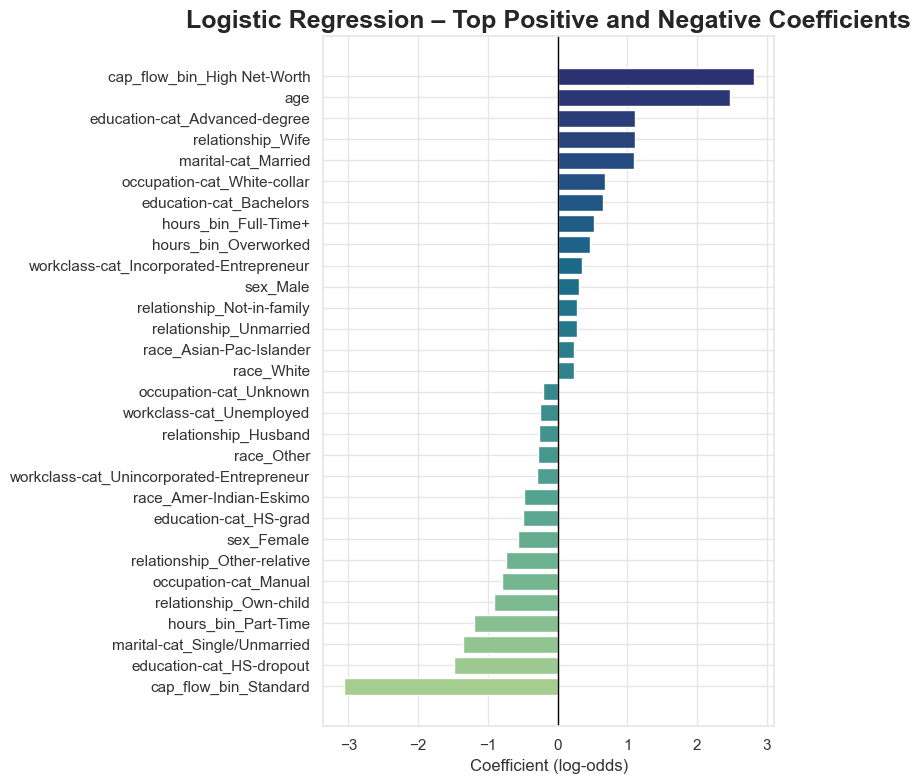

In [134]:


import matplotlib.cm as cm
import numpy as np

plt.figure(figsize=(8,8))

top_coef_sorted = top_coef.sort_values("coef")

# Generate colors from the "crest" colormap
cmap = cm.get_cmap("crest")
colors = cmap(np.linspace(0, 1, len(top_coef_sorted)))

# Create bar chart with colormap colors
plt.barh(top_coef_sorted["feature"], top_coef_sorted["coef"], color=colors)

plt.axvline(0, color="black", linewidth=1)
plt.title("Logistic Regression – Top Positive and Negative Coefficients")
plt.xlabel("Coefficient (log-odds)")
plt.tight_layout()
plt.show()


# RandomForestClassifier
## Build transformers

In [116]:
numeric_transformer_rf = skPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    # no log, no scaler – RF is tree-based and scale-invariant
])

In [117]:
preprocessor_rf = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_rf, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)


## Build pipeline & test using GridSearchCV

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best params (RF): {'clf__max_depth': 20, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 200, 'preprocessor__cat__imputer__strategy': 'constant', 'sampler': RandomOverSampler(random_state=42)}
Best CV accuracy (RF): 0.813033698182906
Test accuracy (RF): 0.8159126365054602
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     12435
           1       0.56      0.82      0.66      3846

    accuracy                           0.80     16281
   macro avg       0.75      0.81      0.76     16281
weighted avg       0.85      0.80      0.82     16281



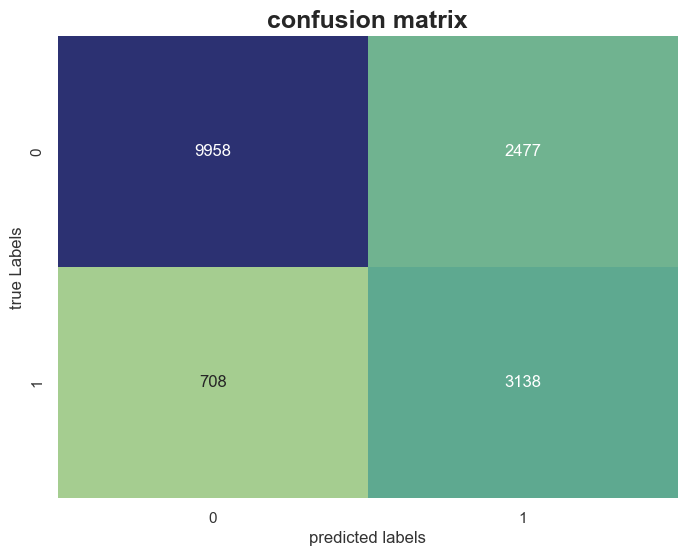

In [118]:
from sklearn.ensemble import RandomForestClassifier

rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
    #class_weight="balanced"
)

rf_pipeline = ImbPipeline(steps=[
    ("prep", BasicPrep()),
    ("preprocessor", preprocessor_rf),
    ("sampler", "passthrough"),
    ("clf", rf_base),
])

rf_param_grid = {
    # cat missing data
    "preprocessor__cat__imputer__strategy": ["most_frequent", "constant"],

    # imbalance handling
    "sampler": [
        "passthrough",
        RandomOverSampler(random_state=42),
    ],

    # RF hyperparams – trimmed
    "clf__n_estimators": [100, 200],       # 400 is overkill for a grid
    "clf__max_depth": [None, 20],          # drop the 10
    "clf__min_samples_leaf": [1, 2],       # drop the 5
}

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    cv=5,
    scoring="recall",
    n_jobs=-1,
    verbose=2
)

rf_grid.fit(X_train_raw, y_train)

print("Best params (RF):", rf_grid.best_params_)
print("Best CV accuracy (RF):", rf_grid.best_score_)

print("Test accuracy (RF):", rf_grid.score(X_test_raw, y_test))
print(classification_report(y_test, rf_grid.predict(X_test_raw)))


y_pred_rf=rf_grid.predict(X_test_raw)

conf= confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8,6))
sns.heatmap(conf, annot=True, cmap= "crest", fmt="d", cbar=False)
plt.xlabel('predicted labels')
plt.ylabel ('true Labels')
plt.title('confusion matrix')
plt.show()

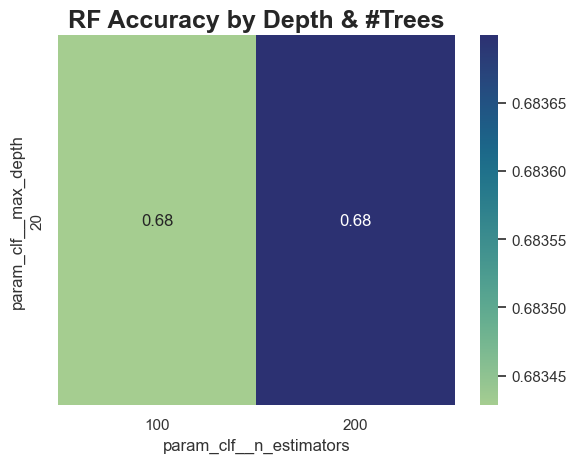

In [119]:
results = pd.DataFrame(rf_grid.cv_results_)

heatmap_data = results.pivot_table(
    values="mean_test_score",
    index="param_clf__max_depth",
    columns="param_clf__n_estimators"
)

sns.heatmap(heatmap_data, annot=True, cmap="crest")
plt.title("RF Accuracy by Depth & #Trees")
plt.show()

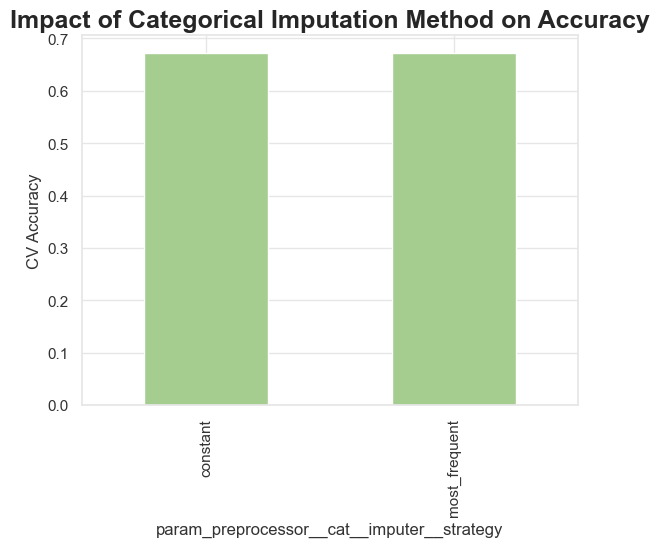

In [120]:
imp_results = results.groupby("param_preprocessor__cat__imputer__strategy")["mean_test_score"].mean()


#imp_results.plot(kind="bar", color=sns.color_palette("YlGnBu", n_colors=len(imp_results)))
imp_results.plot(kind="bar", cmap="crest")
plt.title("Impact of Categorical Imputation Method on Accuracy")
plt.ylabel("CV Accuracy")
plt.show()


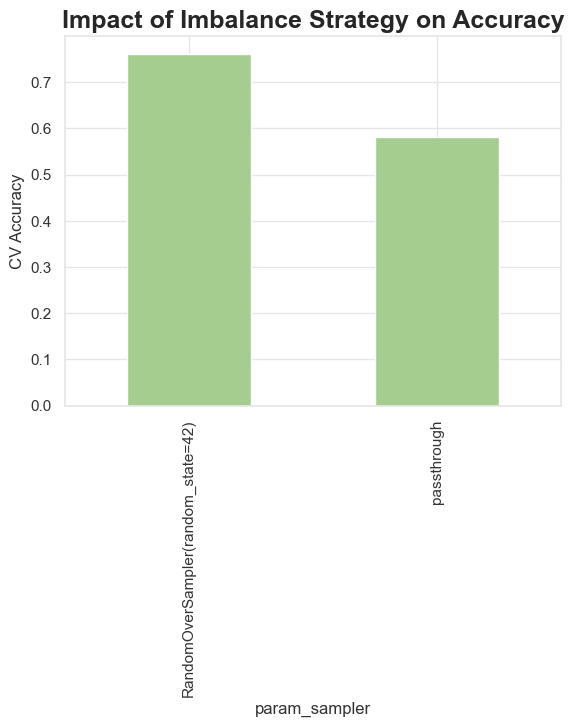

In [121]:
sampling_results = results.groupby("param_sampler")["mean_test_score"].mean()

sampling_results.plot(kind="bar", cmap='crest')
plt.title("Impact of Imbalance Strategy on Accuracy")
plt.ylabel("CV Accuracy")
plt.show()



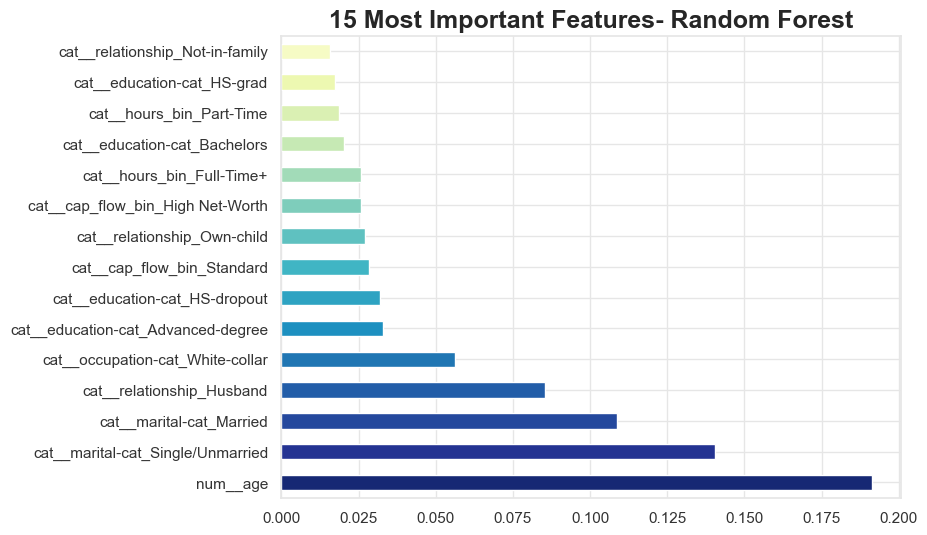

In [122]:
best_rf = rf_grid.best_estimator_.named_steps["clf"]
importances = best_rf.feature_importances_

feature_names = rf_grid.best_estimator_.named_steps["preprocessor"].get_feature_names_out()

fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(15)
fi.plot(kind="barh", figsize=(8,6),color= sns.color_palette("YlGnBu", n_colors=15)[::-1])
plt.title("15 Most Important Features- Random Forest")
plt.show()



In [123]:
logreg_results = pd.DataFrame(logreg_grid.cv_results_)
rf_results = pd.DataFrame(rf_grid.cv_results_)


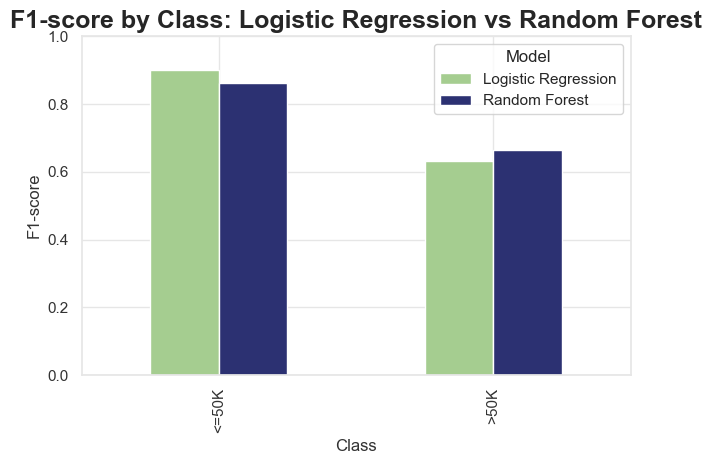

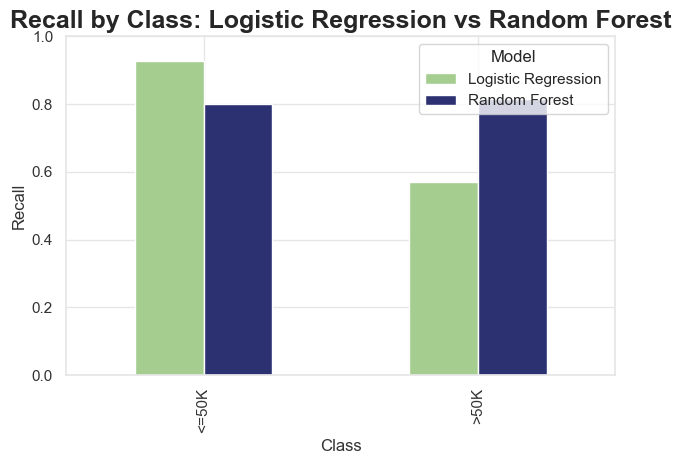

[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=100, preprocessor__cat__imputer__strategy=most_frequent, sampler=passthrough; total time=   8.5s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=100, preprocessor__cat__imputer__strategy=constant, sampler=passthrough; total time=   8.8s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=100, preprocessor__cat__imputer__strategy=constant, sampler=RandomOverSampler(random_state=42); total time=  11.9s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=200, preprocessor__cat__imputer__strategy=most_frequent, sampler=RandomOverSampler(random_state=42); total time=  24.1s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=200, preprocessor__cat__imputer__strategy=constant, sampler=RandomOverSampler(random_state=42); total time=  25.6s
[CV] END clf__max_depth=None, clf__min_samples_leaf=2, clf__n_estimators=100, preprocessor__cat_

Exception ignored in: <function ResourceTracker.__del__ at 0x1026a72e0>
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=100, preprocessor__cat__imputer__strategy=most_frequent, sampler=passthrough; total time=   8.4s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=100, preprocessor__cat__imputer__strategy=most_frequent, sampler=RandomOverSampler(random_state=42); total time=  12.7s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=100, preprocessor__cat__imputer__strategy=constant, sampler=RandomOverSampler(random_state=42); total time=  11.8s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=200, preprocessor__cat__imputer__strategy=most_frequent, sampler=RandomOverSampler(random_state=42); total time=  23.8s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=200, preprocessor__cat__imputer__strategy=constant, sampler=RandomOverSampler(random_state=42); total time=  26.1s
[CV] END clf__max_depth=None, clf__min_samples_leaf=2, clf__n_estima

Exception ignored in: <function ResourceTracker.__del__ at 0x10698f2e0>
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=100, preprocessor__cat__imputer__strategy=most_frequent, sampler=RandomOverSampler(random_state=42); total time=  13.4s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=100, preprocessor__cat__imputer__strategy=constant, sampler=passthrough; total time=   7.9s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=200, preprocessor__cat__imputer__strategy=most_frequent, sampler=passthrough; total time=  14.7s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=200, preprocessor__cat__imputer__strategy=constant, sampler=passthrough; total time=  15.9s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=200, preprocessor__cat__imputer__strategy=constant, sampler=passthrough; total time=  16.3s
[CV] END clf__max_depth=None, clf__min_samples_leaf=2, clf__n_estimators=100, preprocessor__cat__imputer__strategy=most_frequent, sampler=pass

Exception ignored in: <function ResourceTracker.__del__ at 0x1050972e0>
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=100, preprocessor__cat__imputer__strategy=most_frequent, sampler=passthrough; total time=   8.4s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=100, preprocessor__cat__imputer__strategy=constant, sampler=passthrough; total time=   8.7s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=100, preprocessor__cat__imputer__strategy=constant, sampler=RandomOverSampler(random_state=42); total time=  11.7s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=200, preprocessor__cat__imputer__strategy=most_frequent, sampler=passthrough; total time=  14.9s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=200, preprocessor__cat__imputer__strategy=constant, sampler=passthrough; total time=  15.5s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=200, preprocessor__cat__imputer__strategy=constant, sampler=RandomOve

Exception ignored in: <function ResourceTracker.__del__ at 0x10707b2e0>
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=100, preprocessor__cat__imputer__strategy=most_frequent, sampler=passthrough; total time=   8.7s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=100, preprocessor__cat__imputer__strategy=constant, sampler=passthrough; total time=   8.9s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=100, preprocessor__cat__imputer__strategy=constant, sampler=RandomOverSampler(random_state=42); total time=  11.9s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=200, preprocessor__cat__imputer__strategy=most_frequent, sampler=RandomOverSampler(random_state=42); total time=  23.6s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=200, preprocessor__cat__imputer__strategy=constant, sampler=passthrough; total time=  16.3s
[CV] END clf__max_depth=None, clf__min_samples_leaf=2, clf__n_estimators=100, preprocessor__cat__imputer__strategy=most

Exception ignored in: <function ResourceTracker.__del__ at 0x1073fb2e0>
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1029972e0>
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=100, preprocessor__cat__imputer__strategy=most_frequent, sampler=RandomOverSampler(random_state=42); total time=  13.5s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=100, preprocessor__cat__imputer__strategy=constant, sampler=RandomOverSampler(random_state=42); total time=  11.9s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=200, preprocessor__cat__imputer__strategy=most_frequent, sampler=passthrough; total time=  15.1s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=200, preprocessor__cat__imputer__strategy=constant, sampler=passthrough; total time=  15.2s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=200, preprocessor__cat__imputer__strategy=constant, sampler=RandomOverSampler(random_state=42); total time=  25.8s
[CV] END clf__max_depth=None, clf__min_samples_leaf=2, clf__n_estimators=100, preprocessor__cat_

Exception ignored in: <function ResourceTracker.__del__ at 0x10531f2e0>
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104a572e0>
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Applications/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=100, preprocessor__cat__imputer__strategy=most_frequent, sampler=passthrough; total time=   8.4s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=100, preprocessor__cat__imputer__strategy=most_frequent, sampler=RandomOverSampler(random_state=42); total time=  13.0s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=200, preprocessor__cat__imputer__strategy=most_frequent, sampler=passthrough; total time=  14.4s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=200, preprocessor__cat__imputer__strategy=most_frequent, sampler=RandomOverSampler(random_state=42); total time=  23.8s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=200, preprocessor__cat__imputer__strategy=constant, sampler=RandomOverSampler(random_state=42); total time=  26.4s
[CV] END clf__max_depth=None, clf__min_samples_leaf=2, clf__n_estimators=100, preproce

In [125]:
from sklearn.metrics import classification_report

# Get dict reports
lr_report = classification_report(y_test, y_pred_lr, output_dict=True)
rf_report = classification_report(y_test, y_pred_rf, output_dict=True)

# Build DataFrame for plotting
metrics_df = pd.DataFrame({
    ("Logistic Regression", "F1"):    [lr_report["0"]["f1-score"], lr_report["1"]["f1-score"]],
    ("Random Forest",        "F1"):    [rf_report["0"]["f1-score"], rf_report["1"]["f1-score"]],
    ("Logistic Regression", "Recall"): [lr_report["0"]["recall"],   lr_report["1"]["recall"]],
    ("Random Forest",        "Recall"): [rf_report["0"]["recall"],   rf_report["1"]["recall"]],
}, index=["<=50K", ">50K"])

metrics_df.columns = pd.MultiIndex.from_tuples(metrics_df.columns)

# Plot F1 only (simpler) or both
f1_df = metrics_df.xs("F1", axis=1, level=1)

f1_df.plot(kind="bar", cmap= "crest")
plt.title("F1-score by Class: Logistic Regression vs Random Forest")
plt.ylabel("F1-score")
plt.xlabel("Class")
plt.ylim(0, 1)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# If you also want Recall:
recall_df = metrics_df.xs("Recall", axis=1, level=1)
recall_df.plot(kind="bar", cmap= "crest")
plt.title("Recall by Class: Logistic Regression vs Random Forest")
plt.ylabel("Recall")
plt.xlabel("Class")
plt.ylim(0, 1)
plt.legend(title="Model")
plt.tight_layout()
plt.show()


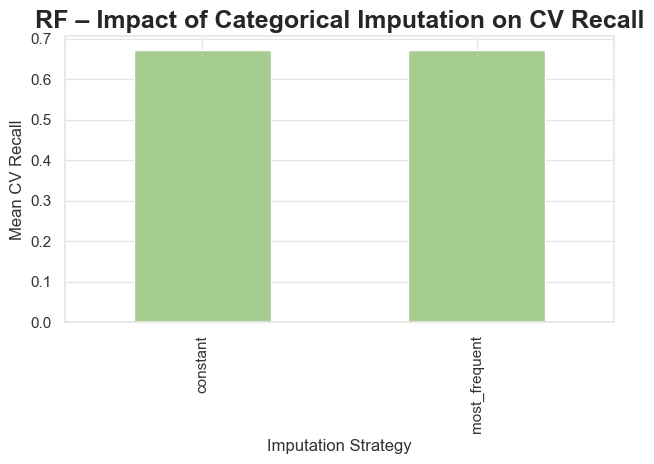

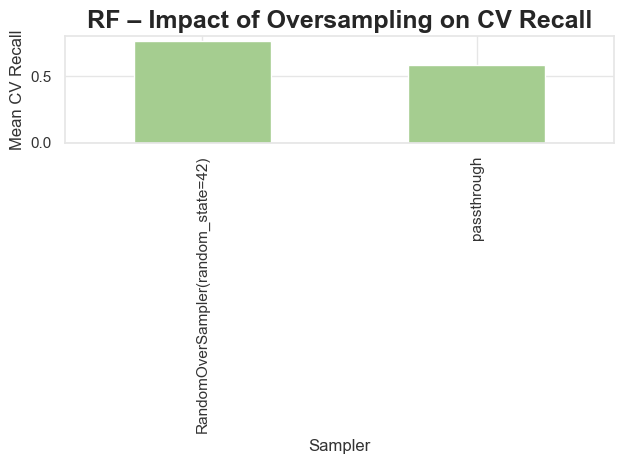

In [128]:
# Example: impact of imputer strategy on mean CV recall (current scoring)
rf_imp_results = rf_results.groupby("param_preprocessor__cat__imputer__strategy")["mean_test_score"].mean()

rf_imp_results.plot(kind="bar", cmap='crest')
plt.title("RF – Impact of Categorical Imputation on CV Recall")
plt.ylabel("Mean CV Recall")
plt.xlabel("Imputation Strategy")
plt.tight_layout()
plt.show()

# Impact of using sampler vs no sampler
rf_sampler_results = rf_results.groupby("param_sampler")["mean_test_score"].mean()

rf_sampler_results.plot(kind="bar",cmap='crest')
plt.title("RF – Impact of Oversampling on CV Recall")
plt.ylabel("Mean CV Recall")
plt.xlabel("Sampler")
plt.tight_layout()
plt.show()
